In [11]:
import os
import random
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import spacy
import string
from wordcloud import WordCloud
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import FastText

# Load the FastText model
fasttext_model = FastText.load("fasttext_300dim_20epochs.model")

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'

# Function to load random documents
def load_random_documents(folder_path, sample_size=5):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()
            if len(content.split()) >= 100:
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

def load_filipino_context_words():
    with open("filipino_context_words.txt", "r", encoding="utf-8") as file:
        filipino__words = [line.strip() for line in file.readlines()]
    return filipino__words
    
documents, file_names = load_random_documents(transcripts_folder_path)

filipino_context_words = load_filipino_context_words()

# Function to load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 'news', 'netherlands', 'psy', 'subtitle', 'description', 'link', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy', 'alright', 'ta', 'day', 'ooh', 'en', 'do', 'lot', 'comment', 'notification', 
    'korean', 'jjajangmyeon', 'jajangmyeon', 'damn', 'yall', 'month', 'week', 'year', 'ohhh', 'pvf', 'dude', 'mmm', 'kagilagilalas', 'ofcourse', 'australia', 'uxo', 
    'atleast', 'yusuf', 'bangkok', 'ot', 'anytime', 'allover', 'kala', 'nope', 'wan', 'brazil', 'smooth', 'ot', 'timeshere', 'batchof', 'yep', 'opo', 'del',
    'gosh', 'po', 'ourself', 'wo', 'wait', 'ugh', 'nyc', 'whoa', 'nicaragua', 'yup', 'em', 'bout', 'le', 'omg', 'overwhelm', 'maam', 'nicer', 'haha', 'hahaha', 'ha', 
    'nbcs', 'lana', 'rc', 'whatsoever', 'oxy', 'decade', 'whyd', 'unknown', 'ahhhhh', 'ohoh', 'ohto', 'ohhhh', 'bruh', 'ooe', 'ahmedabad', 'mexico', 
    'understand', 'excuse', 'kinda', 'applause', 'oooh', 'thiswhat', 'nevermind', 'ahh', 'againthank', 'toto', 'aww', 'nah', 'bbmas', 'ay', 'op', 'huh', 'huhu',
    'tada', 'beacuse', 'voila', 'upstairs', 'thatswhy', 'yea', 'that', 'armenia', 'or', 'not', 'funwhat', 'aka', 'armeniathat', 'woosexy', 'worth', 'laugh', 'box', 
    'xd', 'vb', 'eff', 'ananya', 'welsh', 'latron', 'shout', 'whatwhat', 'what', 'pause', 'why', 'thats', 'byebye', 'iv', 'bye', 'ado', 'ownup', 'dom', 'jomm', 'sir', 
    'budgie', 'nomac', 'lavocha', 'germany', 'why', 'walang', 'superduper', 'philip', 'mom', 'jre', 'giddy', 'intro', 'dupe', 'europe', 'dream', 'team', 'dislike', 'content', 
    'yoongi', 'royale', 'ilu', 'jhope', 'day', 'jin', 'ecc', 'nyhs', 'nego', 'chavez', 'pb', 'everyones', 'epic', 'matter', 'oneonone', 'region', 'change', 'ho', 'seetoh', 
    'atin', 'vpn', 'facetune', 'busu', 'mackie', 'clyd', 'china', 'rest', 'friend', 'woah', 'dindins', 'poster', 'vibe', 'woman', 'boss', 'woah', 'type', 'mahana', 'joke', 
    'taller', 'insane', 'whang', 'psa', 'manatee', 'recommend', 'caesar', 'mmmhmm', 'mosul', 'dun', 'clue', 'naysayer', 'hindi', 'ko', 'pero', 'bulgaria', 'question', 'video', 
    'yobi', 'hindu', 'expat', 'option', 'gap', 'eu', 'simo', 'kouignamann', 'bct', 'month', 'cfo'
]
stop_words.update(custom_stop_words, kpop_keywords, broad_terms, more_keywords, github_stopwords)

lemmatizer = WordNetLemmatizer()

# Identify Filipino words using SpaCy model
def is_filipino_word(word):
    doc = nlp(word)
    embedding = doc.vector
    return np.linalg.norm(embedding) >= 0.85  # Adjust threshold as needed

# Helper function to check if a word contains only Latin script characters
def is_latin_script(word):
    for char in word:
        if not ('LATIN' in unicodedata.name(char, '') or char.isdigit()):
            return False
    return True

def preprocess_text_with_tags(doc, video_id, ngram_range=(1, 2), tag_weight=1, filipino_weight=2, ngram_weight_factor=1):
    doc = doc.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)

    # Step 1: Generate n-grams
    ngram_tokens = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngram_tokens.extend([' '.join(gram) for gram in ngrams(tokens, n)])

    # Step 2: Count n-gram frequency
    ngram_frequencies = Counter(ngram_tokens)

    # Step 3: Filter tokens based on stop words and POS tags
    filtered_tokens = []
    for word, pos in tokens_with_pos:
        if not word.isalpha() or not is_latin_script(word) or word in stop_words:
            continue
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']:
            continue  # Remove verbs and adjectives
        lemmatized_word = lemmatizer.lemmatize(word)
        filtered_tokens.append(lemmatized_word)

    # Step 4: Assign weight based on n-grams and Filipino similarity
    weighted_tokens = []
    for token in filtered_tokens:
        token_weight = 1 + ngram_frequencies.get(token, 0) * ngram_weight_factor  # Weight based on n-grams

        # Apply weight based on FastText similarity to Filipino words
        filipino_similarity = get_filipino_similarity(token)
        if filipino_similarity > 0.3:  # Lower threshold to capture more words
            weighted_tokens.extend([token] * int(filipino_weight * filipino_similarity * token_weight))
        else:
            weighted_tokens.extend([token] * int(token_weight))

    # Step 5: Include video tags
    if video_id in video_tags:
        tags = video_tags[video_id]
        for tag in tags:
            if tag.isalpha() and is_latin_script(tag):
                tag_weight_multiplier = tag_weight
                filipino_similarity = get_filipino_similarity(tag)
                if filipino_similarity > 0.3:
                    tag_weight_multiplier *= filipino_weight * filipino_similarity
                weighted_tokens.extend([tag] * int(tag_weight_multiplier))

    return ' '.join(weighted_tokens)

def get_filipino_similarity(word):
    """Check if a word belongs to the Filipino context based on clustering."""
    if word in filipino_context_words:
        return 1  # Maximum weight if the word is in the discovered Filipino words list
    try:
        # Compute similarity to Filipino words
        similarities = [fasttext_model.wv.similarity(word, ref_word) for ref_word in filipino_context_words if ref_word in fasttext_model.wv]
        return max(similarities) if similarities else 0
    except KeyError:
        return 0


# Function to calculate the number of topics dynamically
def dynamic_num_topics(preprocessed_doc, words_per_topic=200, min_topics=1, max_topics=5):
    num_tokens = len(preprocessed_doc.split())
    return max(min_topics, min(num_tokens // words_per_topic, max_topics))

# Function to display filtered/non-filtered topic-word distributions
def display_topic_word_distributions(lda_model, num_words=20):
    """
    Displays topic-word distributions before and after filtering repeated words.
    
    Args:
        lda_model: Trained LDA model.
        num_words: Number of top words to display per topic.
    """
    # Get non-filtered topics
    non_filtered_topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    # Get filtered topics
    filtered_topics = filter_repeated_words_across_topics(lda_model, num_words=num_words)
    
    # Display non-filtered topics
    print("\nNon-Filtered Topic-Word Distributions:")
    for t, words in non_filtered_topics:
        print(f"Topic {t}: {words}")
    
    # Display filtered topics
    print("\nFiltered Topic-Word Distributions:")
    for t, words in filtered_topics:
        print(f"Topic {t}: {words}")

# Function to display both filtered and non-filtered WordClouds in a grid layout
def display_wordclouds_grid(lda_model, video_id, num_words=50):
    """
    Displays both filtered and non-filtered WordClouds for each topic in a grid layout.
    Skips topics with no words to plot.
    
    Args:
        lda_model: Trained LDA model.
        video_id: Identifier for the video/document.
        num_words: Number of top words to consider for WordCloud.
    """
    num_words = int(num_words)  # Ensure num_words is an integer
    # Get non-filtered topics
    non_filtered_topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    # Get filtered topics
    filtered_topics = filter_repeated_words_across_topics(lda_model, num_words=num_words)
    
    # Remove topics with no words to plot (for filtered topics)
    filtered_topics = [(t, words) for t, words in filtered_topics if words]
    
    # If no topics left to plot, return
    if not filtered_topics and not non_filtered_topics:
        print(f"No WordClouds to display for {video_id} (all topics empty).")
        return
    
    # Calculate number of rows and columns for the grid
    num_topics = max(len(non_filtered_topics), len(filtered_topics))
    num_rows = num_topics  # One row per topic
    num_cols = 2  # Two columns: one for non-filtered, one for filtered
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    fig.suptitle(f"WordClouds for {video_id} (Left: Non-Filtered, Right: Filtered)", fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Generate and display WordClouds for non-filtered topics
    for i, (t, words) in enumerate(non_filtered_topics):
        # Generate word frequency dictionary for the WordCloud
        word_freq = {word[0]: word[1] for word in words}
        wordcloud = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(word_freq)
        
        # Display the WordCloud in the left column
        axes[2 * i].imshow(wordcloud, interpolation="bilinear")
        axes[2 * i].set_title(f"Topic {t} (Non-Filtered)", fontsize=12)
        axes[2 * i].axis("off")
    
    # Generate and display WordClouds for filtered topics
    for i, (t, words) in enumerate(filtered_topics):
        # Generate word frequency dictionary for the WordCloud
        word_freq = {word[0]: word[1] for word in words}
        wordcloud = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(word_freq)
        
        # Display the WordCloud in the right column
        axes[2 * i + 1].imshow(wordcloud, interpolation="bilinear")
        axes[2 * i + 1].set_title(f"Topic {t} (Filtered)", fontsize=12)
        axes[2 * i + 1].axis("off")
    
    # Hide unused subplots
    for j in range(2 * i + 2, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

    # Display the preprocessed document
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.5, preprocessed_doc, fontsize=12, wrap=True, ha='center', va='center', multialignment='left')
    plt.axis("off")
    plt.title(f"{video_id}_preprocessedDoc", fontsize=16)
    plt.show()

# Function to display raw LDA results
def display_raw_lda_results(lda_model):
    """
    Displays raw topic-word distributions from the LDA model.
    
    Args:
        lda_model: Trained LDA model.
    """
    print("\nRaw LDA Topic-Word Distributions:")
    topics = lda_model.show_topics(formatted=False)
    for t, words in topics:
        print(f"Topic {t}: {words}")

# Function to display LDA evaluation metrics
def display_lda_evaluation_metrics(lda_model, corpus, dictionary, preprocessed_doc):
    """
    Displays evaluation metrics for the LDA model.
    
    Args:
        lda_model: Trained LDA model.
        corpus: Gensim corpus.
        dictionary: Gensim dictionary.
        preprocessed_doc: Preprocessed document content.
    """
    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)
    print(f"\nPerplexity: {perplexity}")
    
    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=[preprocessed_doc.split()], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score: {coherence_score}")

# Dictionary to store preprocessed documents mapped to video IDs
preprocessed_docs = {}

# LDA topic modeling
lda_models = []
topic_vectors = []

# Function to filter repeated words across topics
def filter_repeated_words_across_topics(lda_model, num_words=20):
    """
    Filters repeated words across topics for a single document.
    Ensures each word appears in only one topic.

    Args:
        lda_model: Trained LDA model for a document.
        num_words: Number of top words to consider per topic.

    Returns:
        filtered_topics: List of filtered topics where words don't repeat.
    """
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    used_words = set()
    filtered_topics = []

    for t, words in topics:
        filtered_words = []
        for word, prob in words:
            if word not in used_words:
                filtered_words.append((word, prob))
                used_words.add(word)
        filtered_topics.append((t, filtered_words))

    return filtered_topics

Processing file: bTLMJvuPbZc_captions.txt
Processing file: btEYK52Dwsc_captions.txt
Processing file: 4SOtYIJpO3w_captions.txt
Processing file: jahAi_wkHAs_captions.txt
Processing file: 0nRXbv67-4M_captions.txt

Results for bTLMJvuPbZc:

Non-Filtered Topic-Word Distributions:
Topic 0: [('dish', 0.2905987), ('milk', 0.1111112), ('asukal', 0.0769231), ('time', 0.06837608), ('sugar', 0.059829056), ('tuesday', 0.059829056), ('comment', 0.042735014), ('monggo', 0.042735014), ('ginataang', 0.034187995), ('mungo', 0.034187995), ('request', 0.034187995), ('letton', 0.034187995), ('city', 0.025640978), ('oil', 0.025640978), ('garden', 0.025640978), ('ingredient', 0.017093971), ('bean', 0.017093971)]

Filtered Topic-Word Distributions:
Topic 0: [('dish', 0.2905987), ('milk', 0.1111112), ('asukal', 0.0769231), ('time', 0.06837608), ('sugar', 0.059829056), ('tuesday', 0.059829056), ('comment', 0.042735014), ('monggo', 0.042735014), ('ginataang', 0.034187995), ('mungo', 0.034187995), ('request', 0.0

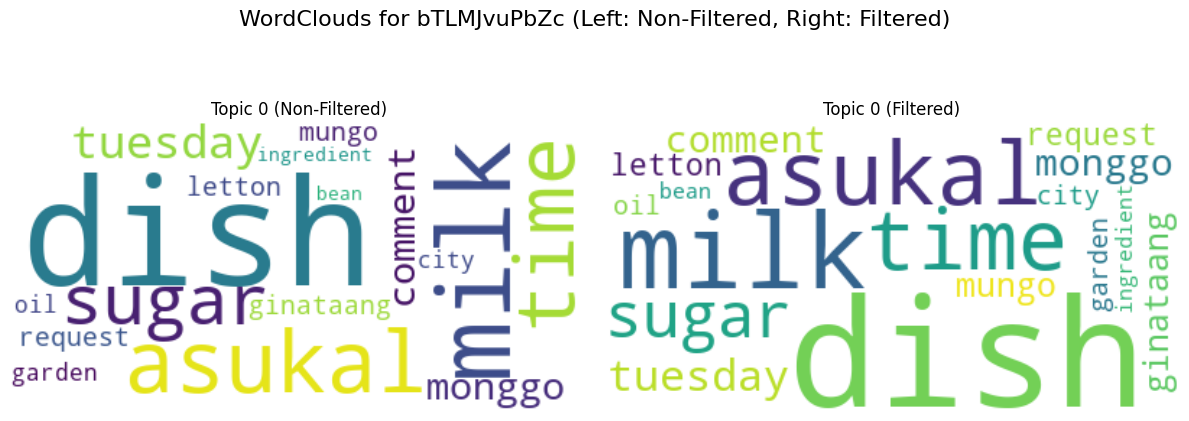

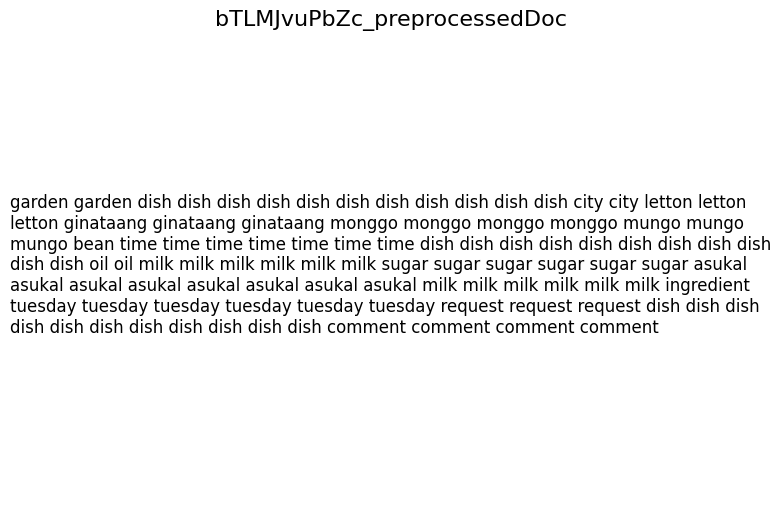


Results for btEYK52Dwsc:

Non-Filtered Topic-Word Distributions:
Topic 0: [('man', 0.12970762), ('family', 0.07949817), ('girl', 0.037656967), ('guzman', 0.037656967), ('story', 0.037656967), ('chris', 0.029288733), ('storage', 0.029288733), ('crazy', 0.029288733), ('sketch', 0.029288733), ('jr', 0.029288733), ('heard', 0.025104614), ('performer', 0.020920495), ('gay', 0.020920495), ('comedy', 0.020920495), ('advice', 0.020920495), ('pizza', 0.020920495), ('goodbye', 0.016736379), ('college', 0.016736379), ('dad', 0.016736379), ('trucker', 0.016736379)]

Filtered Topic-Word Distributions:
Topic 0: [('man', 0.12970762), ('family', 0.07949817), ('girl', 0.037656967), ('guzman', 0.037656967), ('story', 0.037656967), ('chris', 0.029288733), ('storage', 0.029288733), ('crazy', 0.029288733), ('sketch', 0.029288733), ('jr', 0.029288733), ('heard', 0.025104614), ('performer', 0.020920495), ('gay', 0.020920495), ('comedy', 0.020920495), ('advice', 0.020920495), ('pizza', 0.020920495), ('goodby

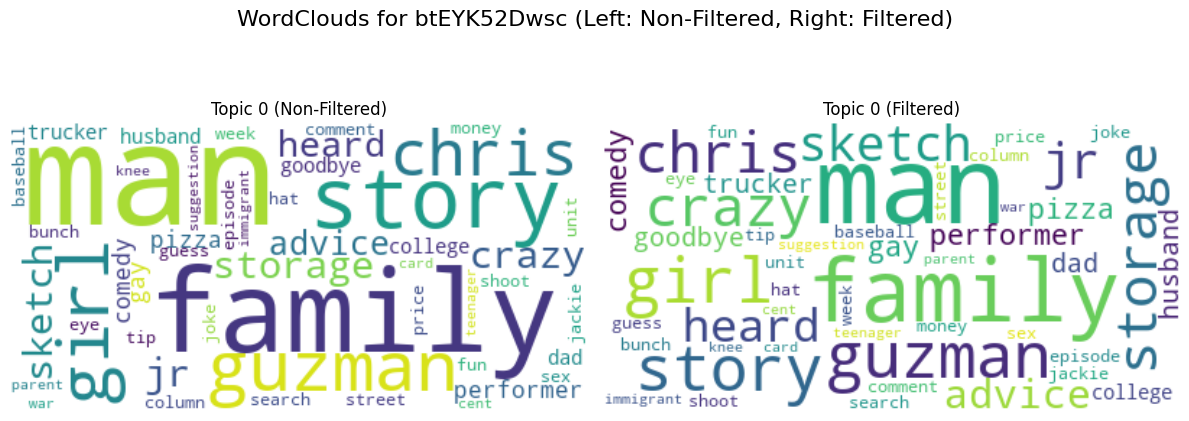

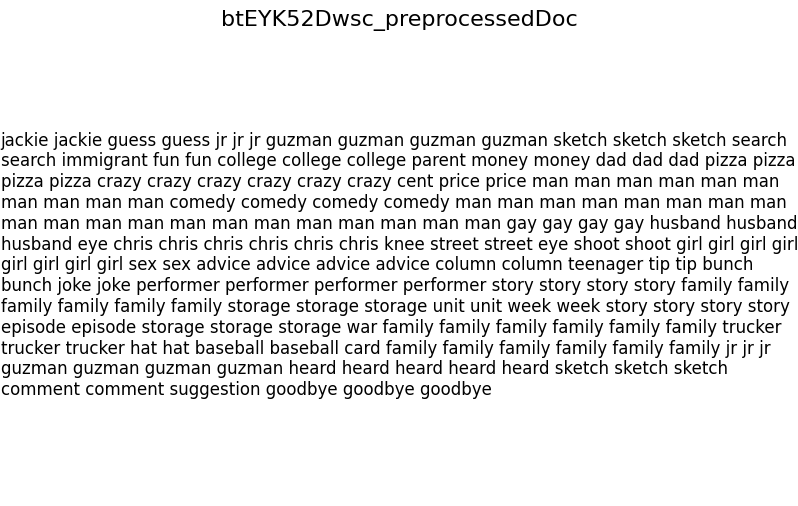


Results for 4SOtYIJpO3w:

Non-Filtered Topic-Word Distributions:
Topic 0: [('cebu', 0.0041842153), ('city', 0.004184149), ('mactan', 0.004184122), ('mall', 0.004184121), ('traffic', 0.004184117), ('night', 0.004184115), ('month', 0.004184112), ('rent', 0.0041841115), ('park', 0.004184109), ('beach', 0.0041841073), ('downtown', 0.0041841064), ('cologne', 0.004184106), ('plenty', 0.0041841054), ('resort', 0.0041841045), ('district', 0.0041841036), ('condo', 0.0041841036), ('taxi', 0.0041841026), ('motorbike', 0.004184102), ('peso', 0.004184102), ('movie', 0.0041841017)]
Topic 1: [('cebu', 0.0042045773), ('city', 0.004189262), ('mactan', 0.004187995), ('mall', 0.0041875765), ('traffic', 0.004187019), ('night', 0.0041860603), ('rent', 0.0041849436), ('month', 0.0041847904), ('beach', 0.00418478), ('plenty', 0.004184752), ('resort', 0.0041847466), ('park', 0.0041847364), ('cologne', 0.004184726), ('taxi', 0.0041845585), ('downtown', 0.0041844803), ('movie', 0.0041844803), ('condo', 0.00418

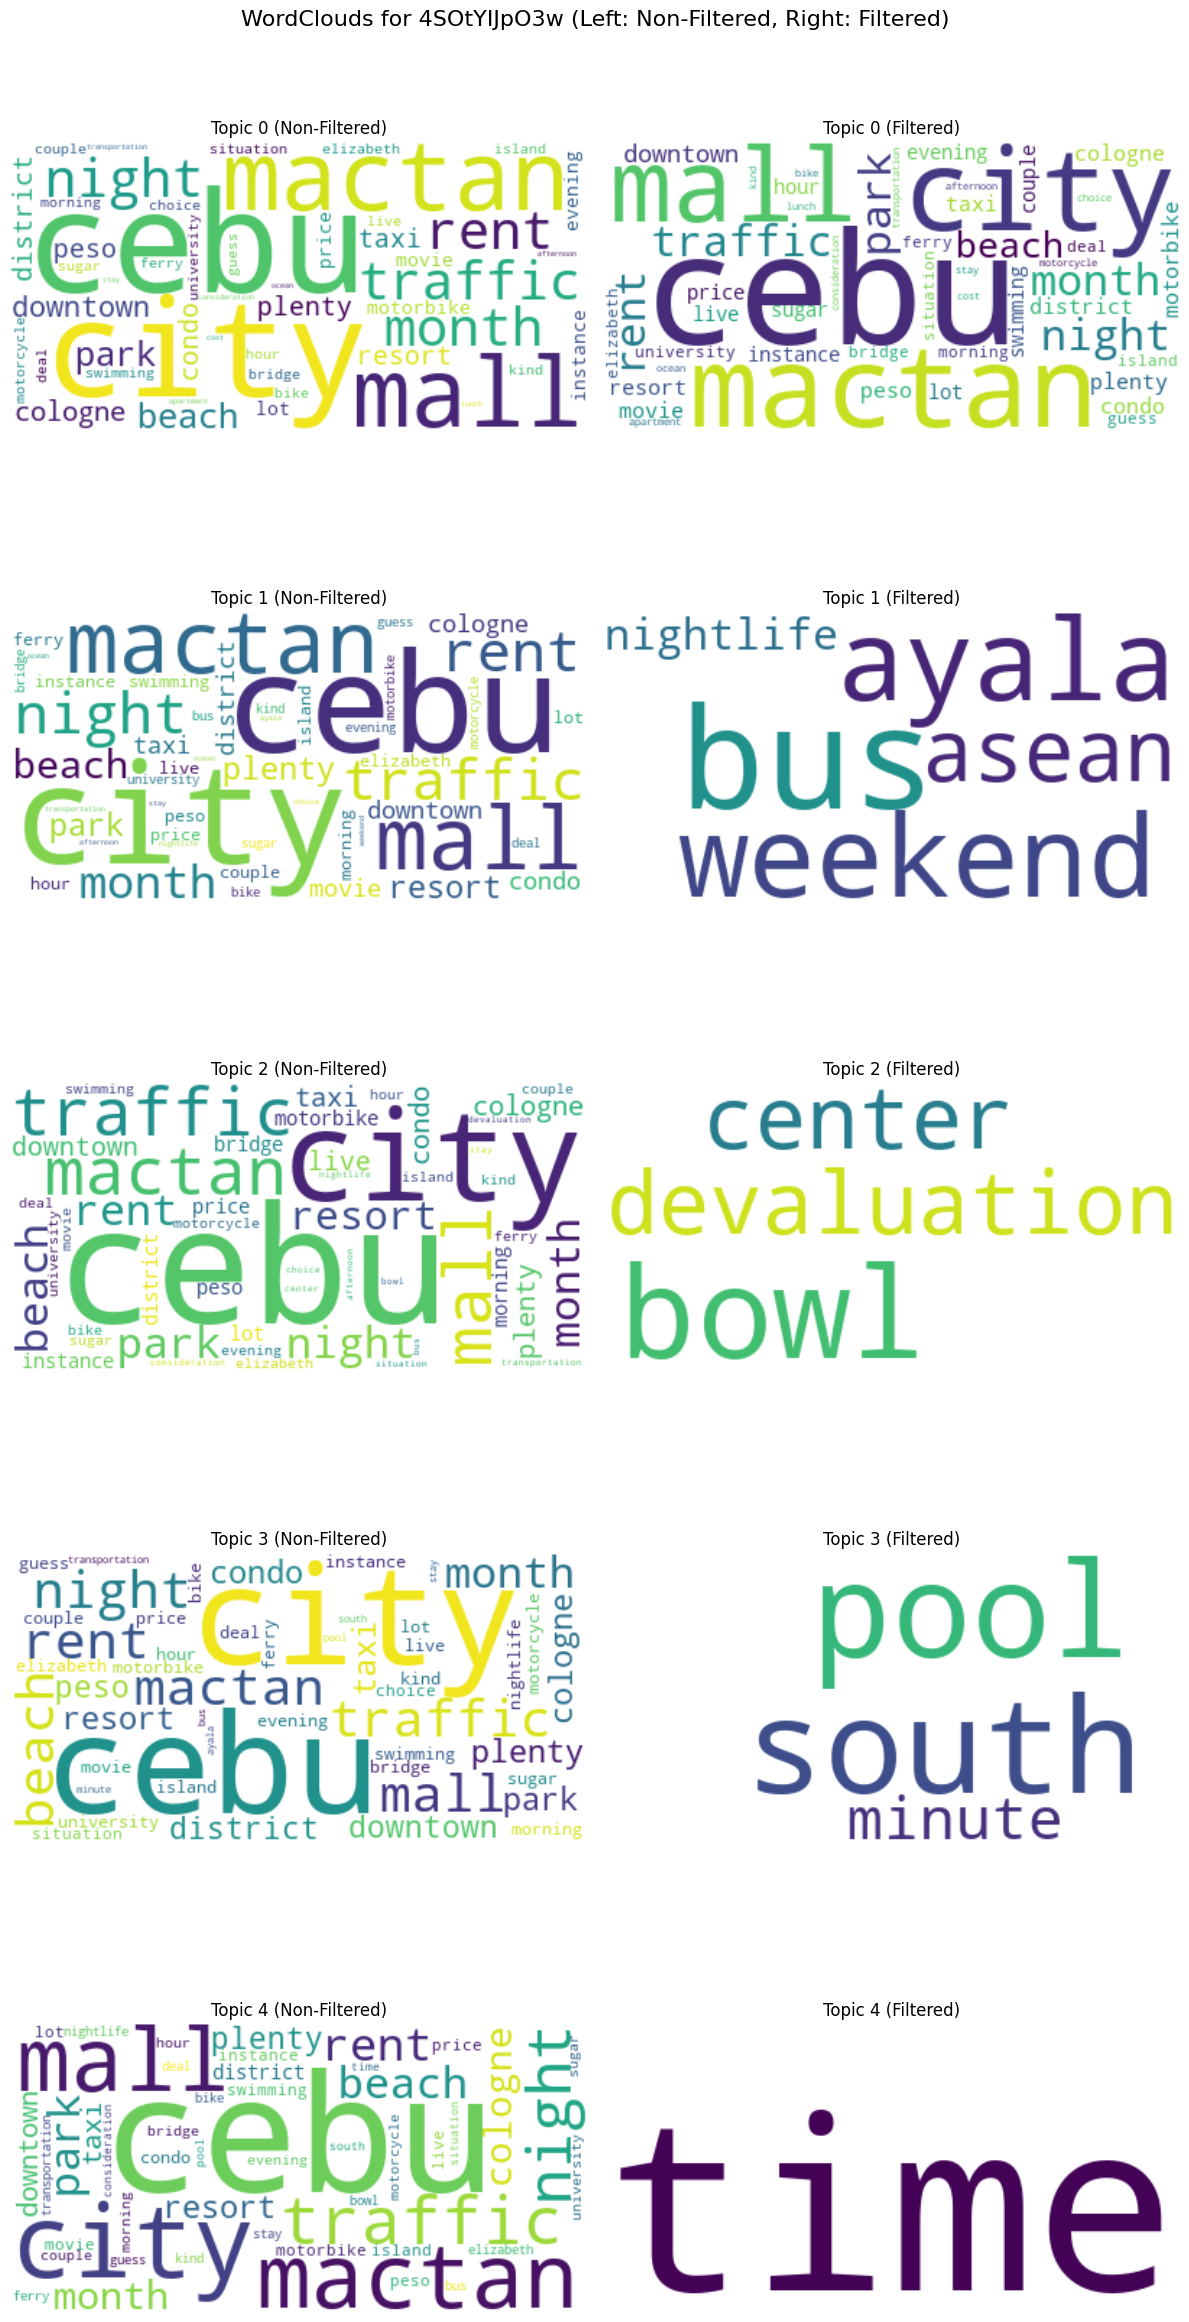

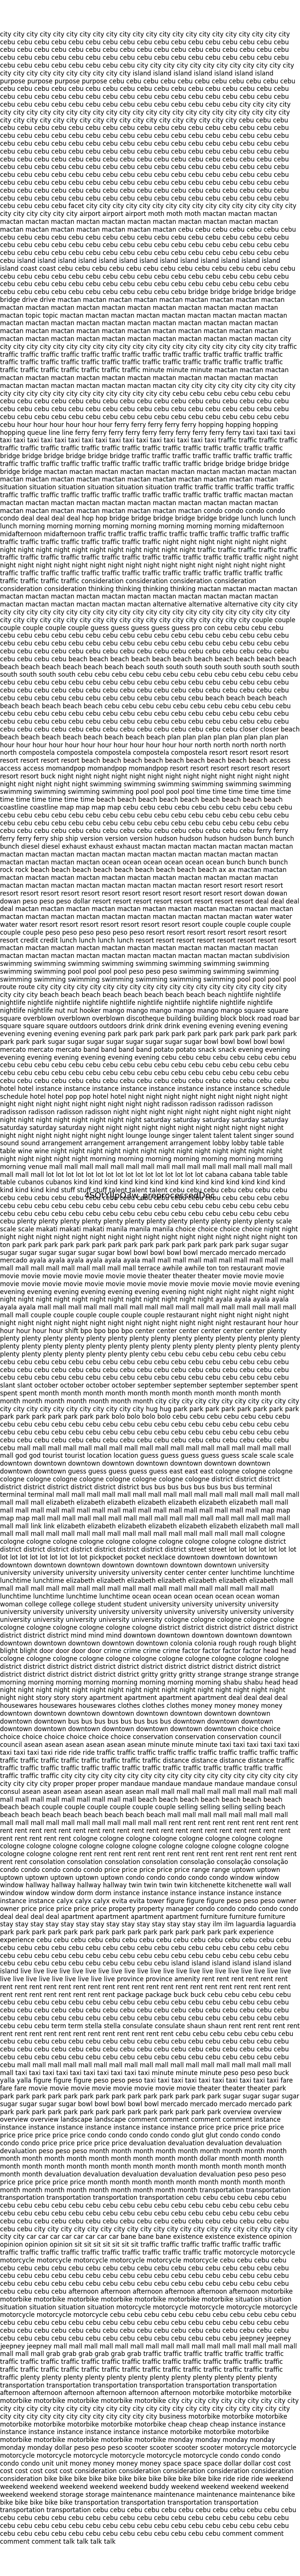


Results for jahAi_wkHAs:

Non-Filtered Topic-Word Distributions:
Topic 0: [('cebu', 0.012827336), ('city', 0.012825218), ('jeepney', 0.012822133), ('olga', 0.012821357), ('shipping', 0.012821352), ('makeup', 0.0128213065), ('security', 0.012821191), ('afternoon', 0.012821153), ('matcha', 0.01282095), ('boracay', 0.012820893), ('day', 0.012820873), ('capital', 0.01282081), ('photo', 0.012820803), ('guard', 0.012820778), ('friend', 0.012820728), ('car', 0.012820712), ('aboard', 0.0128207), ('magnate', 0.012820693), ('watching', 0.012820602), ('breathe', 0.012820601)]
Topic 1: [('cebu', 0.1720656), ('city', 0.11502693), ('jeepney', 0.04658056), ('olga', 0.03137026), ('makeup', 0.029468967), ('photo', 0.023765117), ('day', 0.023765117), ('afternoon', 0.023765096), ('security', 0.023765095), ('shipping', 0.02376508), ('breathe', 0.016159957), ('watching', 0.016159957), ('magnate', 0.01615995), ('car', 0.01615995), ('friend', 0.016159948), ('guard', 0.016159944), ('capital', 0.016159942), (

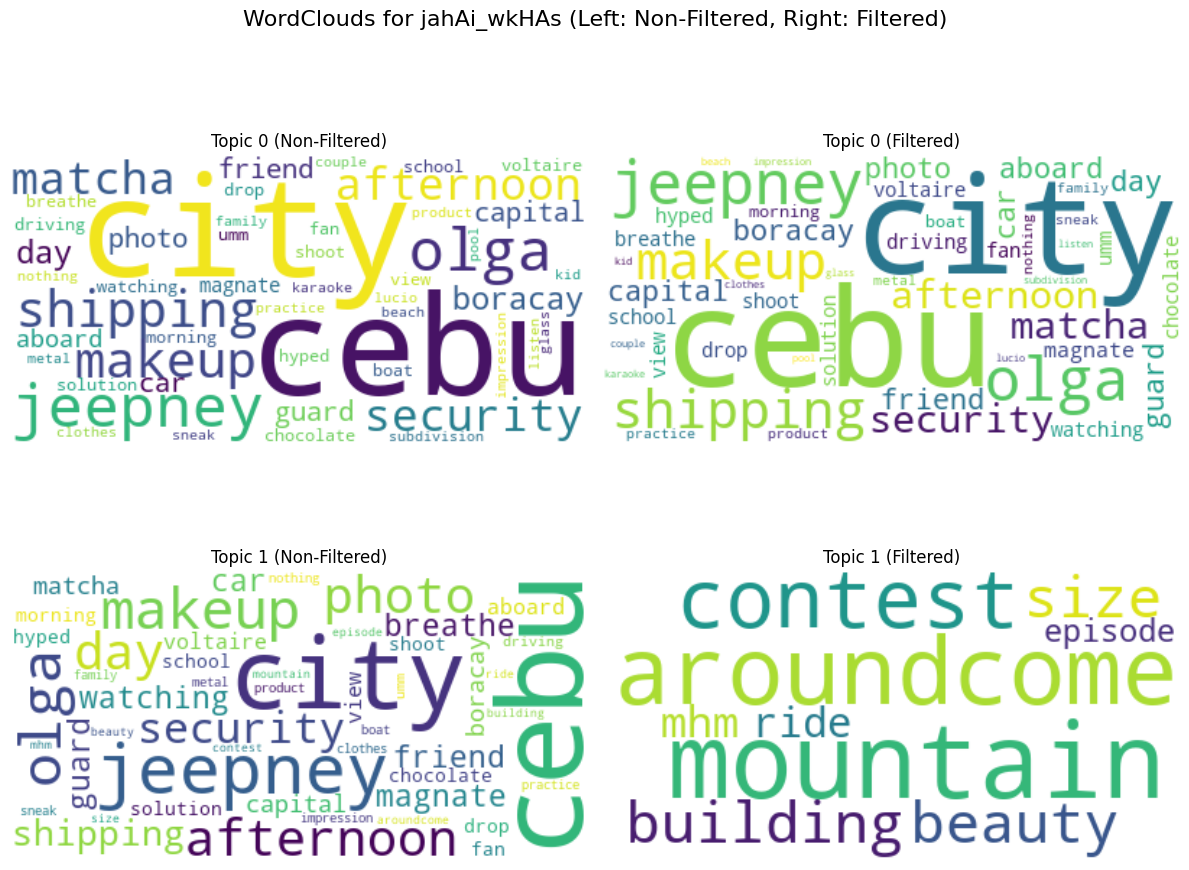

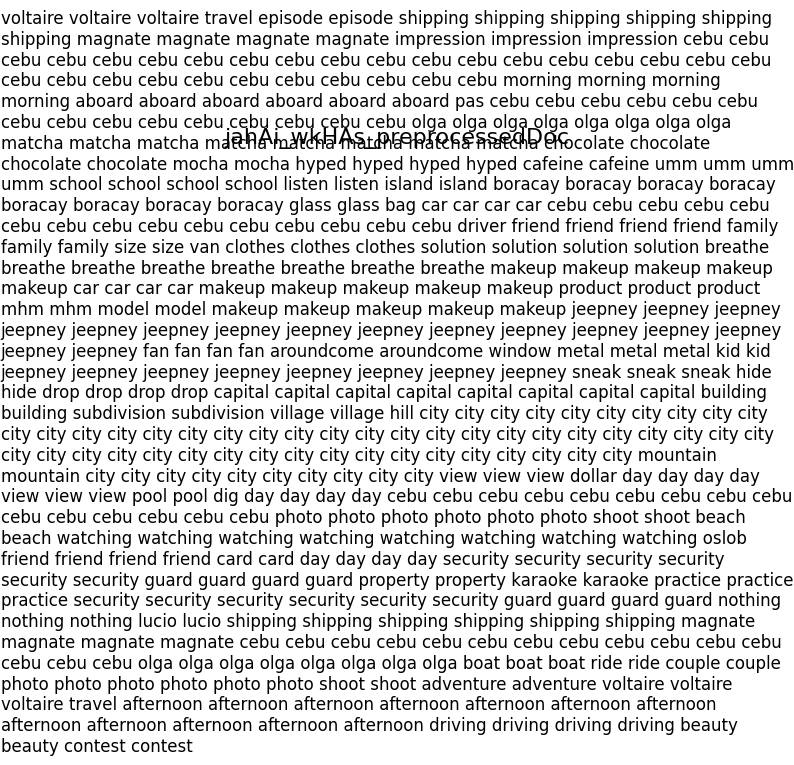


Results for 0nRXbv67-4M:

Non-Filtered Topic-Word Distributions:
Topic 0: [('pancake', 0.007147366), ('coffee', 0.0071443603), ('watermelon', 0.007143778), ('market', 0.0071437424), ('pork', 0.0071432986), ('manila', 0.007143219), ('juice', 0.00714311), ('shop', 0.0071430104), ('grab', 0.007142999), ('cheese', 0.0071429983), ('barbecue', 0.0071429494), ('street', 0.0071429405), ('spring', 0.007142925), ('marinade', 0.0071429145), ('button', 0.007142901), ('walking', 0.007142895), ('roll', 0.0071428926), ('cup', 0.007142884), ('yam', 0.0071428814), ('favorite', 0.007142874)]
Topic 1: [('pancake', 0.26241285), ('coffee', 0.09169181), ('watermelon', 0.06342671), ('market', 0.061165515), ('pork', 0.03403105), ('manila', 0.034031037), ('juice', 0.025551518), ('shop', 0.018202594), ('cheese', 0.015941389), ('street', 0.014245481), ('grab', 0.013680178), ('button', 0.010288371), ('barbecue', 0.010288371), ('marinade', 0.010288368), ('spring', 0.010288368), ('yam', 0.008592464), ('city', 0.00

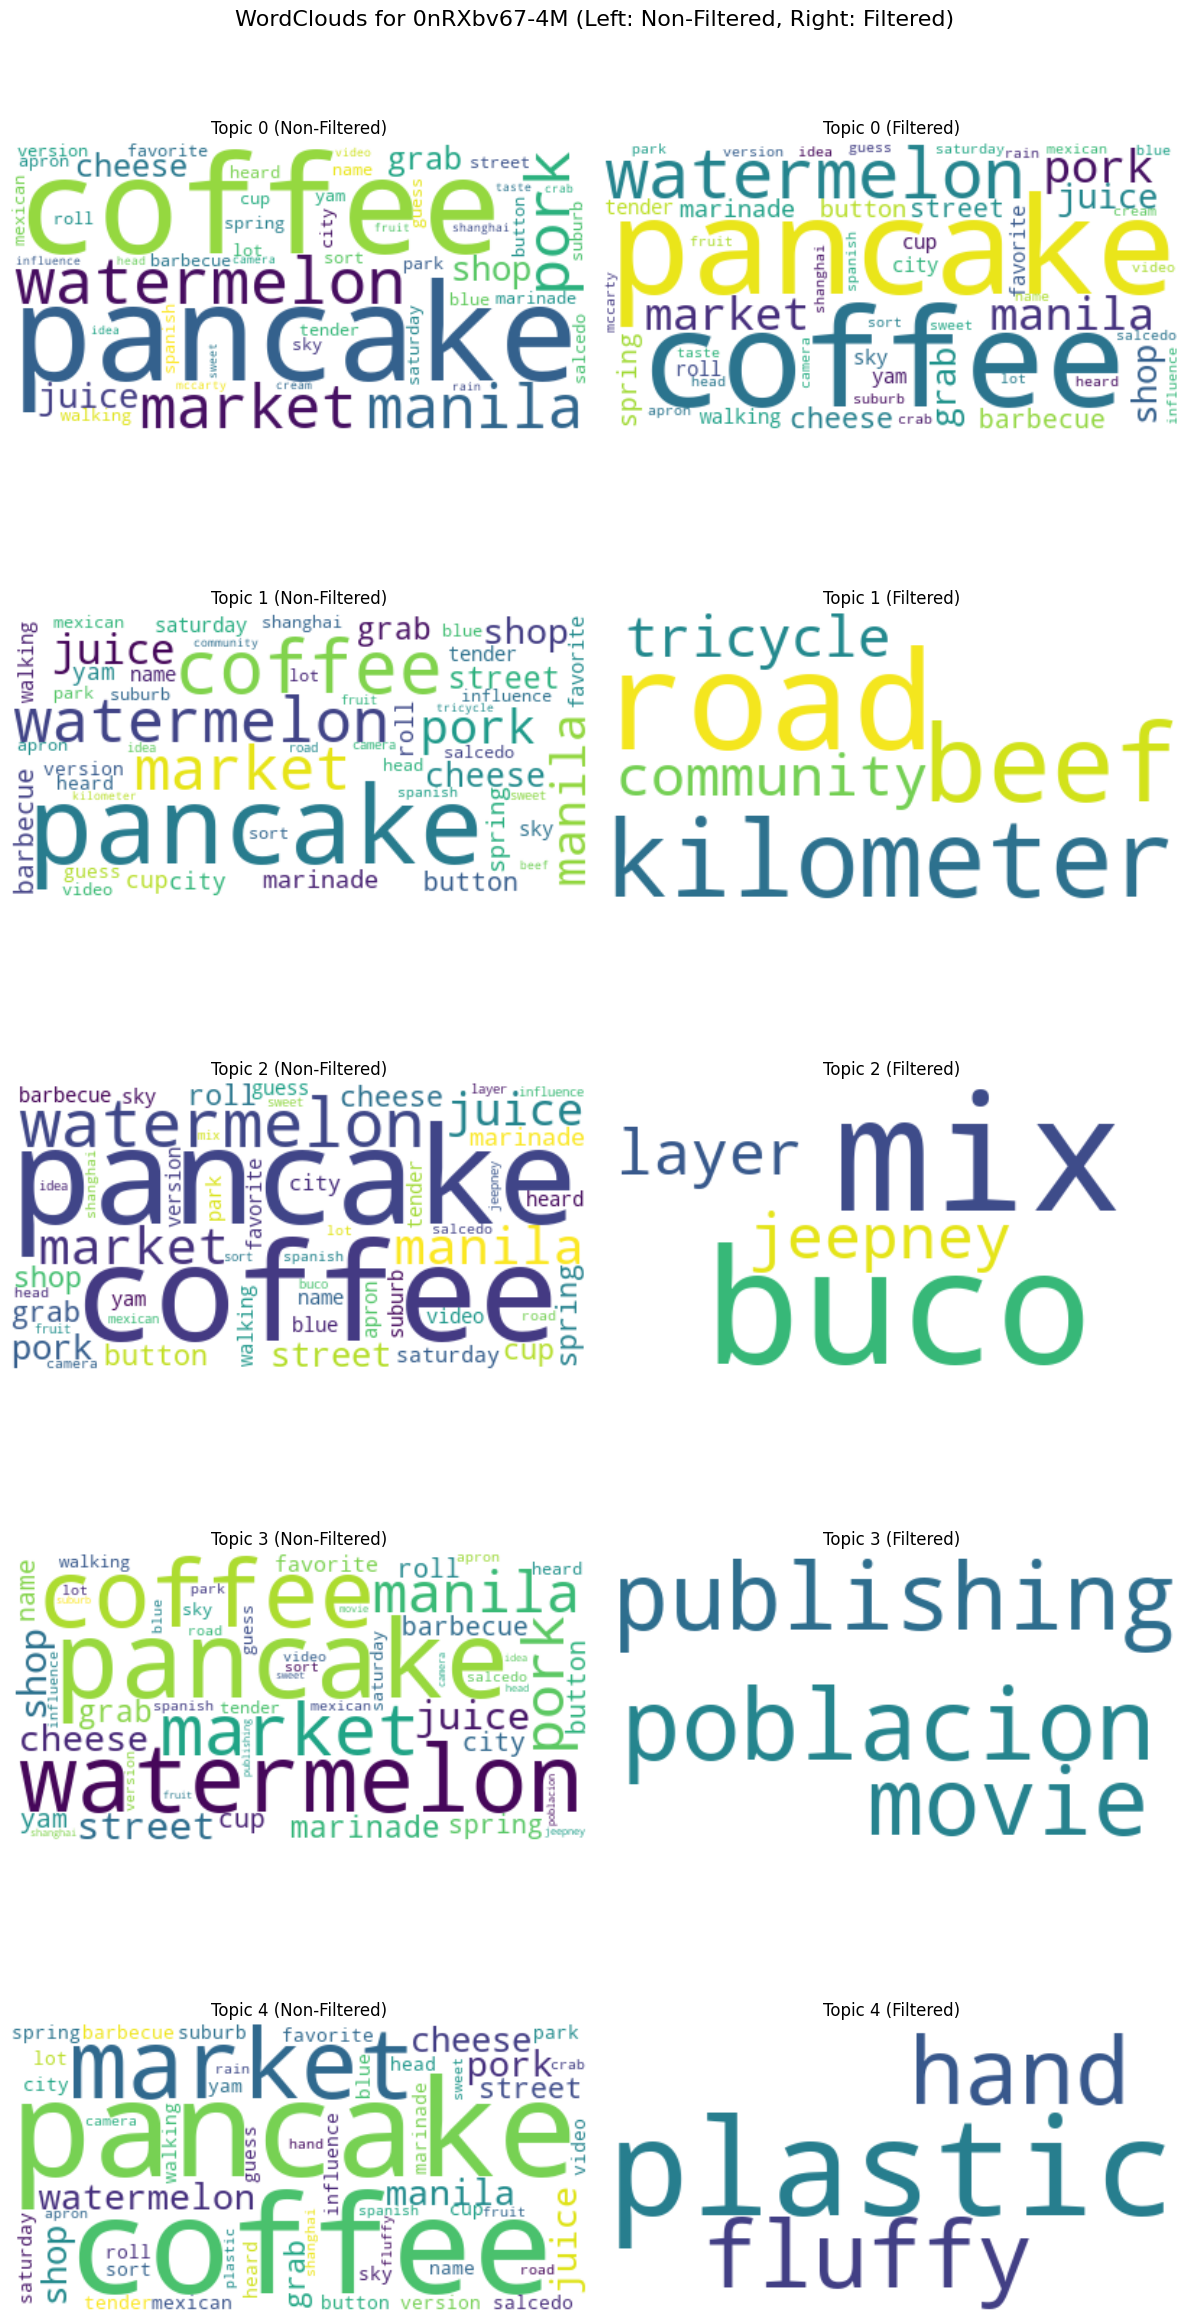

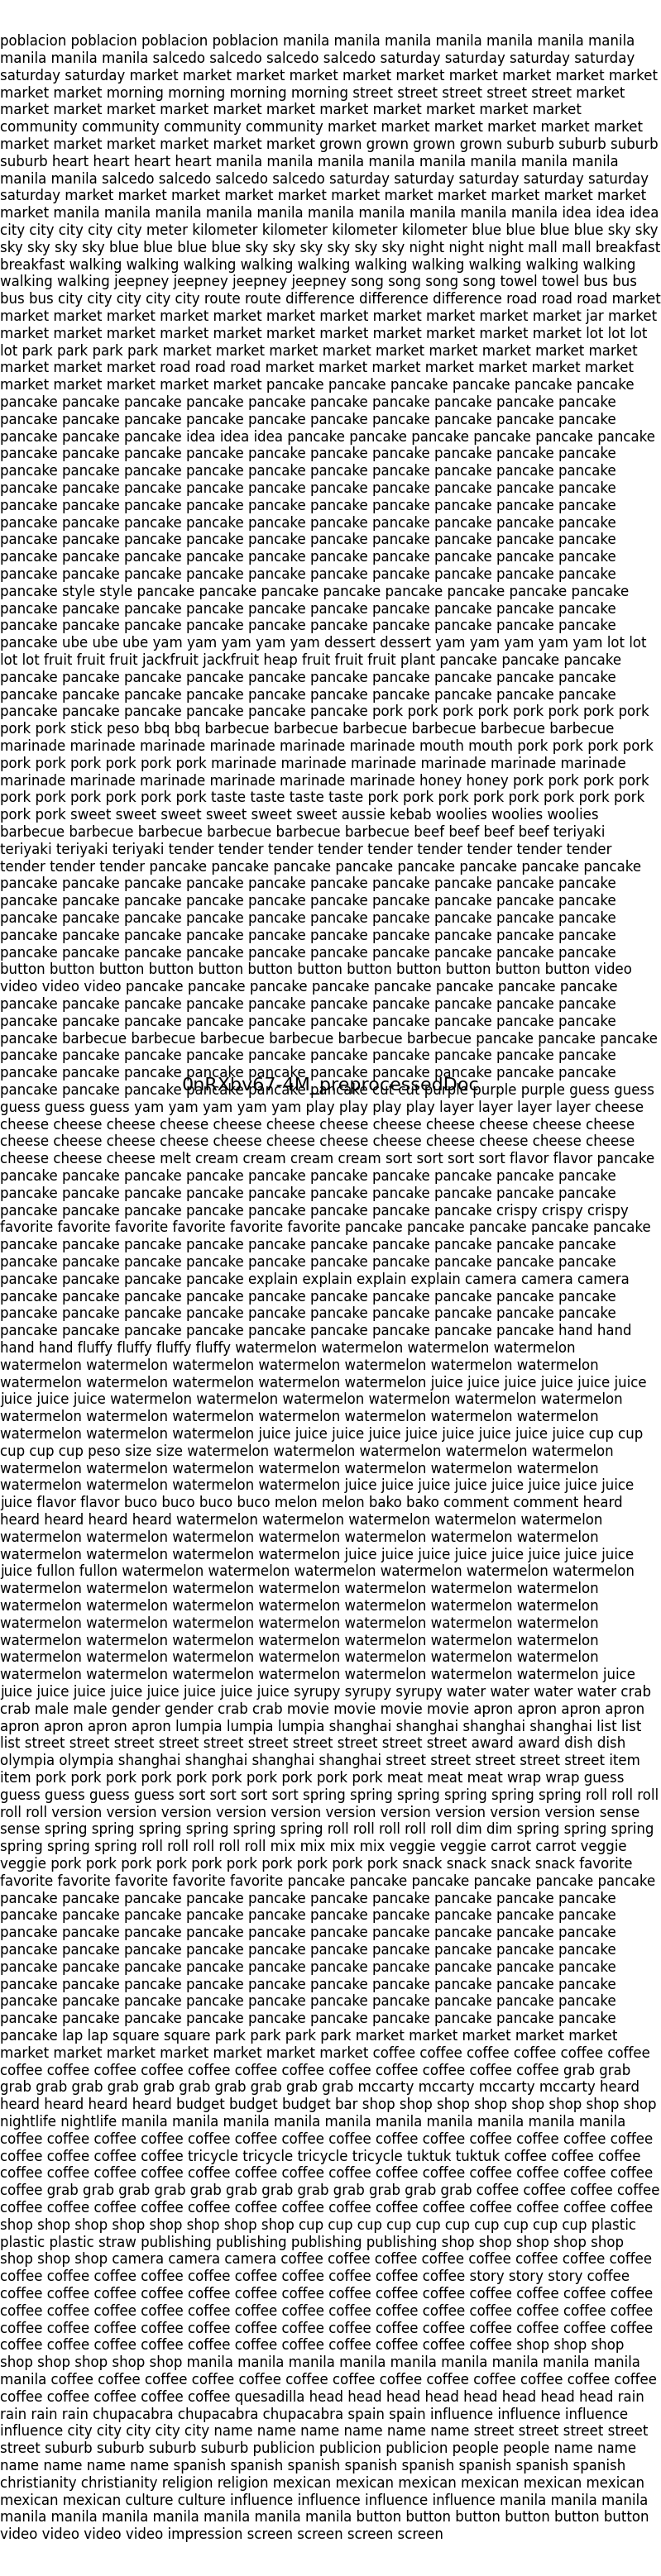

In [12]:
for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")

    preprocessed_doc = preprocess_text_with_tags(doc, video_id)
    preprocessed_docs[video_id] = preprocessed_doc

    if len(preprocessed_doc) > 0:
        dictionary = corpora.Dictionary([preprocessed_doc.split()])
        corpus = [dictionary.doc2bow(preprocessed_doc.split())]
        
        num_topics = dynamic_num_topics(preprocessed_doc, words_per_topic=200, min_topics=1, max_topics=5)
        #print(f"Number of topics for {video_id}: {num_topics}")

        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, eta='auto', alpha='auto', passes=50, random_state=42)
        lda_models.append(lda_model)

        topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
        topic_vector = [prob for _, prob in topic_distribution]
        topic_vectors.append(topic_vector)

# Main loop to process and display results
for i, lda_model in enumerate(lda_models):
    video_id = file_names[i].split('_captions')[0]
    preprocessed_doc = preprocessed_docs[video_id]
    
    print(f"\nResults for {video_id}:")

    # Display topic-word distributions (filtered vs non-filtered)
    display_topic_word_distributions(lda_model)
    
    # Display evaluation metrics
    dictionary = corpora.Dictionary([preprocessed_doc.split()])
    corpus = [dictionary.doc2bow(preprocessed_doc.split())]
    display_lda_evaluation_metrics(lda_model, corpus, dictionary, preprocessed_doc)
    
    # Display WordClouds in a grid layout
    display_wordclouds_grid(lda_model, video_id)